In [1]:
# Environment bootstrap
import sys
from pathlib import Path
import joblib

ROOT = Path().resolve().parents[0]
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

In [2]:
# Project imports
from src.paths import PROJECT_ROOT
from src.config import load_config
from src.data_loader import load_processed_data
from src.results_loader import load_all_metrics, load_all_threshold_sweeps
from src.artifacts_io import load_split
from src.visualization.comparison import plot_model_comparison, plot_precision_vs_recall_at_chosen_threshold
from src.visualization.thresholds import plot_precision_recall_tradeoff
from src.visualization.explainability import make_shap_report

In [3]:
# Constants and selection criteria
MIN_RECALL = 0.80
MIN_PRECISION = 0.50

In [4]:
# Load config/data
cfg = load_config()
df = load_processed_data()

In [5]:
# Paths + load artifacts (pipeline + threshold)
ARTIFACTS_DIR = PROJECT_ROOT / cfg["paths"]["artifacts_dir"]
SPLIT_DIR = PROJECT_ROOT / cfg["paths"]["split_dir"]
FINAL_DIR = PROJECT_ROOT / cfg['paths']['final_dir']


run_path = FINAL_DIR
pipeline = joblib.load(run_path / "pipeline.joblib")
threshold = joblib.load(run_path / "threshold.joblib")

In [6]:
# Load split + build X_train / X_test / proba
split = load_split(SPLIT_DIR)
test_idx = split["test_idx"]
y_test = split["y_test"]

feature_cols = cfg["features"]["numerical"] + cfg["features"]["categorical"]

X_test = df.loc[test_idx, feature_cols].copy()
X_train = df.drop(index=test_idx)[feature_cols].copy()

proba = pipeline.predict_proba(X_test)[:, 1]

In [7]:
# Load all models metrics and thresholds results
models_results = load_all_metrics(ARTIFACTS_DIR)
models_thresholds = load_all_threshold_sweeps(ARTIFACTS_DIR)

In [8]:
# Rank models by specific order
ranked_models = models_results.sort_values(
    by=[c for c in ["pr_auc", "roc_auc", "recall", "precision"] if c in models_results.columns],
    ascending=False
)
ranked_models

,run_dir,model,threshold,precision,recall,f1_score,roc_auc,pr_auc,fp,fn,tp,tn,accuracy
2,gb_tuned,gb_tuned,0.10,0.717949,0.823529,0.767123,0.985081,0.838707,22,12,56,1910,0.9830
3,final,gb_tuned,0.10,0.717949,0.823529,0.767123,0.985081,0.838707,22,12,56,1910,0.9830
0,rf_tuned,rf_default_tuned,0.06,0.305419,0.911765,0.457565,0.961553,0.796959,141,6,62,1791,0.9265
1,lr_default_tuned,lr_default_tuned,0.02,0.105647,0.852941,0.188006,0.888922,0.455572,491,10,58,1441,0.7495
4,lr_balanced_tuned,lr_balanced_tuned,0.58,0.157895,0.750000,0.260870,0.889394,0.395515,272,17,51,1660,0.8555


In [9]:
# Define best model by pre-defined business threshold 
candidate_models = ranked_models[
    (ranked_models['recall'] >= MIN_RECALL) & 
    (ranked_models['precision'] >= MIN_PRECISION)
].copy()
candidate_models

,run_dir,model,threshold,precision,recall,f1_score,roc_auc,pr_auc,fp,fn,tp,tn,accuracy
2,gb_tuned,gb_tuned,0.1,0.717949,0.823529,0.767123,0.985081,0.838707,22,12,56,1910,0.983
3,final,gb_tuned,0.1,0.717949,0.823529,0.767123,0.985081,0.838707,22,12,56,1910,0.983


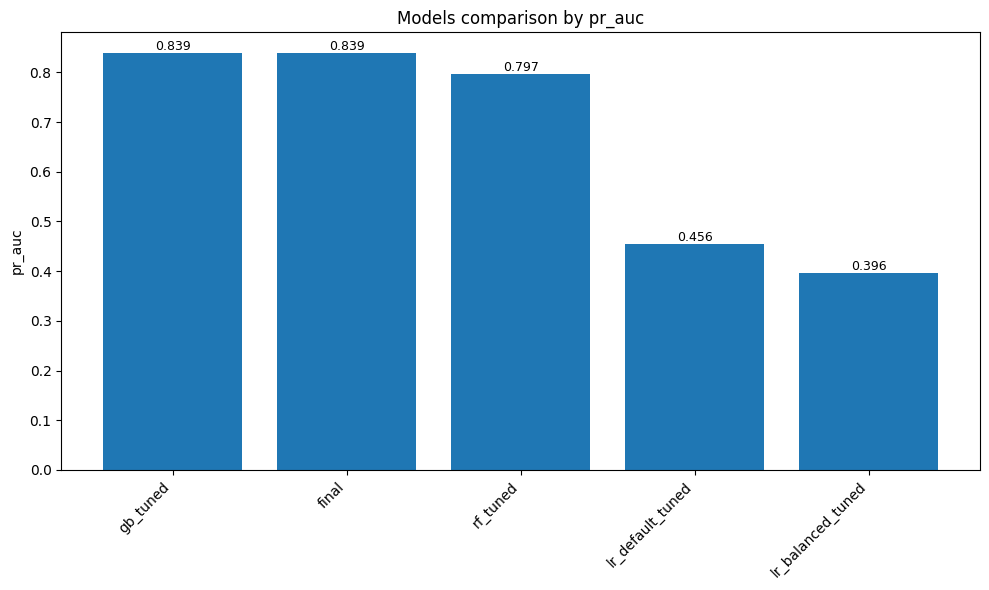

In [10]:
plot_model_comparison(models_results, "pr_auc")

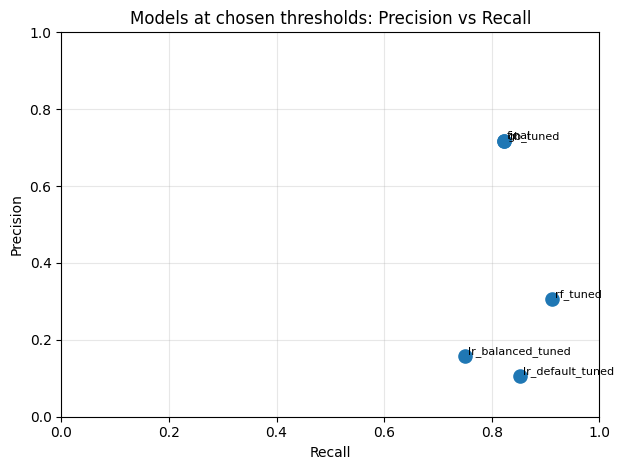

In [11]:
plot_precision_vs_recall_at_chosen_threshold(models_results)

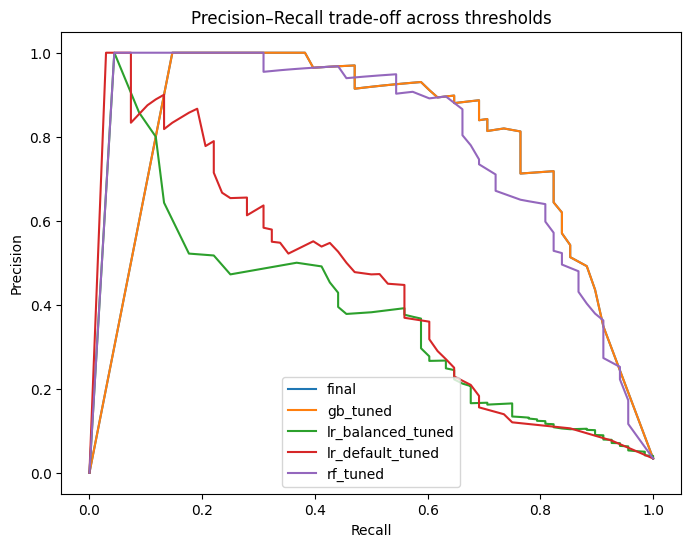

In [12]:
plot_precision_recall_tradeoff(models_thresholds)

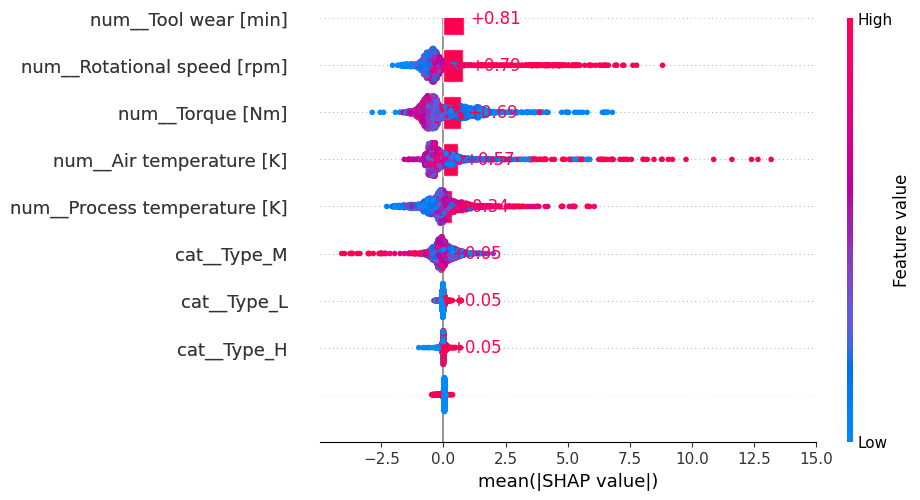

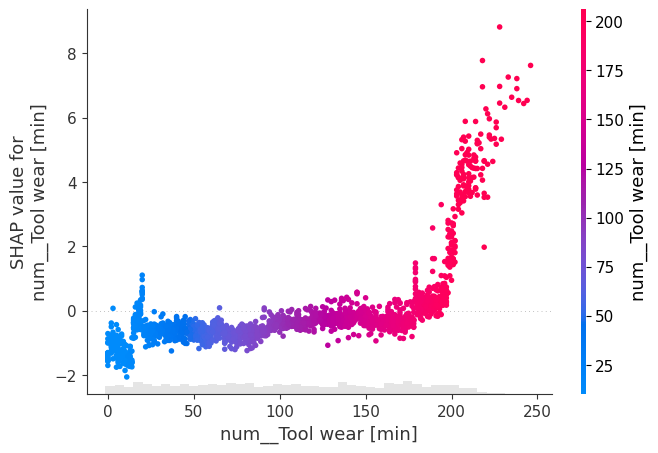

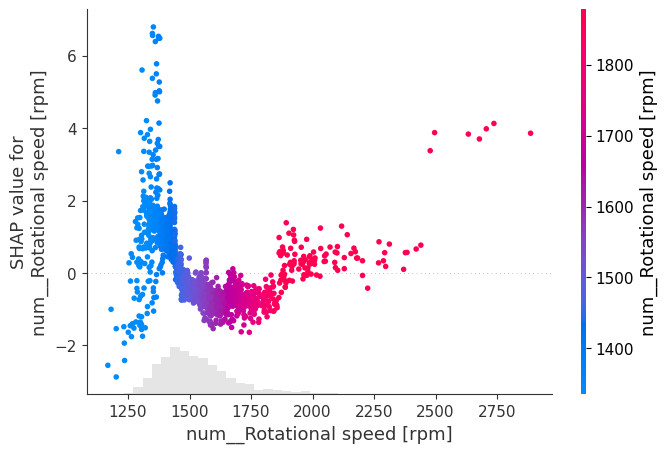

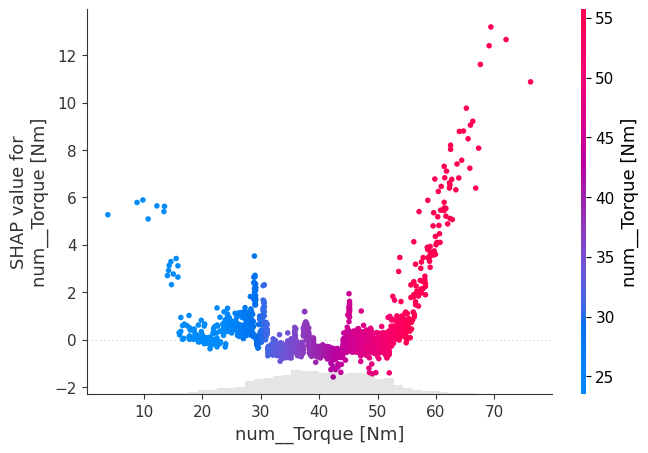

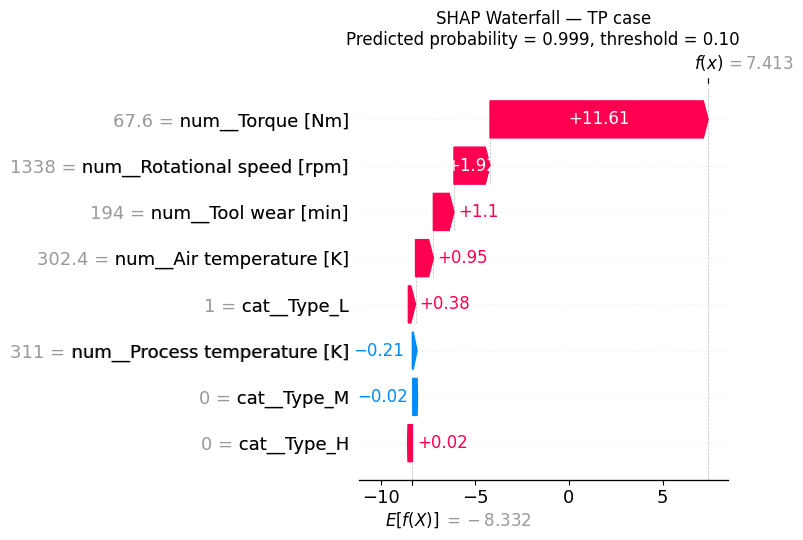

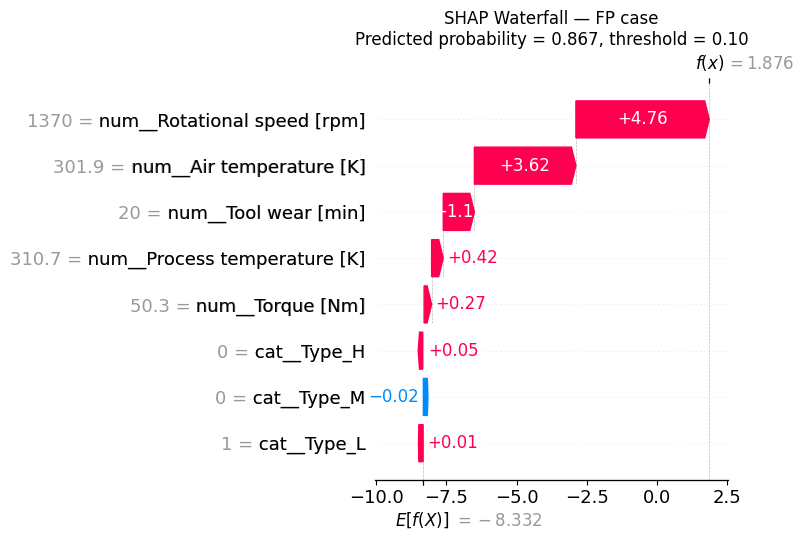

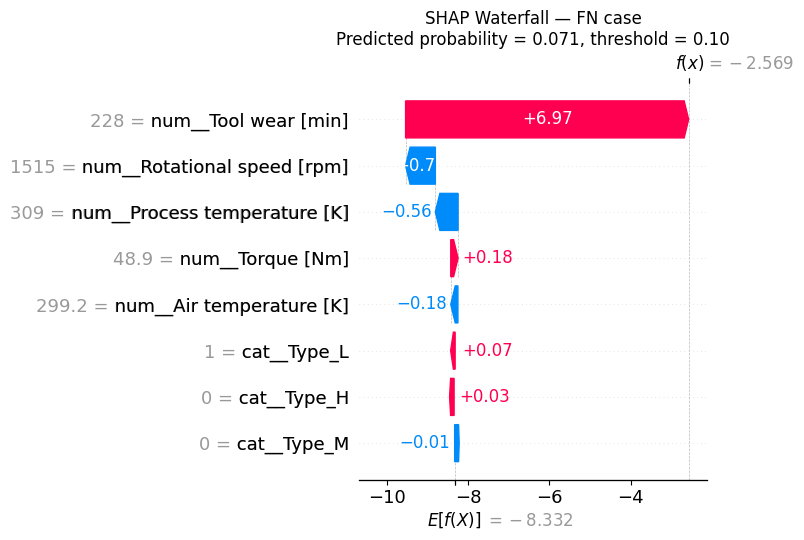

In [13]:
report = make_shap_report(
    pipeline=pipeline,
    X_train=X_train,
    X_test=X_test,
    y_true=y_test,
    proba=proba,
    threshold=threshold,
    max_display=20,
    top_dependence=3,
    waterfall_kinds=None
)

# Predictive Maintenance — Final Model

## Goal
Build a production-ready predictive maintenance system that detects machine failures early (**high recall**) while keeping the alert volume manageable (**minimum acceptable precision**).

---

## Data
- Source: `data/raw/milling_machine.csv`
- Processed: `data/processed/milling_machine.parquet`
- Target: `Machine failure` (binary, highly imbalanced)

---

## Project Structure
- `notebooks/`
  - `01_eda.ipynb` — exploratory data analysis
  - `02_baseline_models.ipynb` — logistic regression baselines
  - `03_tree_models.ipynb` — random forest models
  - `04_gradient_boosting_models.ipynb` — gradient boosting models
  - `05_model_selection_and_explainability.ipynb` — final selection, visualization, SHAP
- `src/` — reusable project code (preprocessing, training, evaluation, thresholding, visualization)
- `artifacts/` — saved model runs and evaluation artifacts

---

## Model Selection Criteria

Final model selection is driven by **explicit business constraints**, not by default metrics.

### Hard constraints
- **Minimum recall:** `≥ 0.80`
- **Minimum precision:** `≥ 0.50`

Models failing to satisfy **both** constraints are excluded from consideration.

### Ranking logic
Among the remaining candidates, models are ranked by:
1. **PR-AUC** (primary ranking metric)
2. **ROC-AUC**
3. **Recall**
4. **Precision**

This ensures both strong ranking quality and a robust operating point.

---

## Final Model Selection

### Selected model
**Run directory:** `artifacts/final`  
**Model:** Gradient Boosting Classifier  
**Decision threshold:** **0.10**

This is the **only model** satisfying both business constraints simultaneously.

---

## Final Performance (Test Set)

At the chosen operating point:

- **Recall:** **0.8235**
- **Precision:** **0.7179**
- **F1-score:** **0.7671**
- **ROC-AUC:** **0.9851**
- **PR-AUC:** **0.8387**

**Confusion matrix breakdown:**
- True Positives (TP): **56**
- False Positives (FP): **22**
- False Negatives (FN): **12**
- True Negatives (TN): **1910**

---

## Why This Model Was Selected

- Meets **both** minimum business requirements for recall and precision.
- Achieves the **highest PR-AUC** among all eligible models, indicating superior ranking quality for rare failure events.
- Maintains a strong balance between early failure detection and alert reliability.
- Demonstrates excellent separation between failure and non-failure cases (ROC-AUC ≈ 0.99).
- Provides a stable and interpretable operating point suitable for production deployment.

---

## Explainability

Model decisions are interpreted using **SHAP**:

- **Global explanations**
  - SHAP beeswarm plot (overall feature impact)
  - SHAP bar plot (mean absolute importance)
- **Feature behavior**
  - Dependence plots for top contributing features
- **Local explanations**
  - Waterfall plots for representative:
    - true positives (TP)
    - false positives (FP)
    - false negatives (FN)

This allows explanations of the form:
> “The model predicted failure primarily due to elevated torque and tool wear, combined with abnormal temperature behavior.”

---

## Saved Artifacts

All inference-time artifacts are stored under: `artifacts/final/`

Contents:
- `metrics.json` — evaluation metrics at chosen threshold
- `pipeline.joblib` — full preprocessing + model pipeline
- `proba_test.npy` — predicted failure probabilities on test set
- `threshold_sweep.csv` — precision–recall trade-off across thresholds
- `threshold.joblib` — selected decision threshold (0.10)

Train/test split metadata is stored separately under: `artifacts/split/`

---

## Status
✅ **Model ready for production deployment**  
The system exposes:
- a calibrated decision threshold,
- predictable alert behavior,
- strong explainability,
- and a reproducible inference pipeline.

Further improvements (e.g. cost-sensitive optimization or online recalibration) can be layered on top without architectural changes.
